In [244]:
import glob
import pandas as pd
from array import ArrayType
import numpy as np

# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 
import os
# saveFolderName = "peak"
genSavePath = f"{os.getcwd()}/SavedResults/"

In [245]:
import paradigmSetting
day = "12" # Which month and days result you want to visualize in table
month = 12

nrOfLabels = 4


cmbSize = 2
repetitionValue = 1
# featureSelect = "myOwnTestAvg2" # 
# featureSelect = "myOwnTestSadAngryHappyDisgusted"
featureSelect = "myOwnTestUpDownLeftRight"

paradigm = paradigmSetting.sadAngryHappyDisgustedJulia()
# featureSelect = "4UpDownLeftRight" # 
paradigm = paradigmSetting.UpDownLeftRightJulia()
myDataset = True
# featureSelect = "myOwnTestAvgRef" #  
# featureSelect = "nietoTest" # 
# paradigm = paradigmSetting.upDownRightLeftInner()
# paradigm = paradigmSetting.upDownRightLeftInner()
# paradigm = paradigmSetting.rightLeftInner()

# featureSelect = "OnlySepOnlyCurr01thTESTHoldOut70"
paraName = paradigm[0]
labels = np.arange(nrOfLabels) 
saveTables = True
saveTop = True
saveHoldTop = True
saveSepTop = True
saveAvgTop = False
import matplotlib as mpl
mpl.rcParams["figure.dpi"]  = 80


In [246]:
repetitionName = f"{paraName}{cmbSize}c{featureSelect}" #"debuggingOnlyCurrthreeAv2correct" #"debuggingOnlyPreNotCurrthreeAv2Correct"# "testAvgDoubleBC4labelsinner2c" # "testAvgDoubleBC4labels1c" # #"peak4-const3-i-ud-global-10-3c"  # "i-ud-global-05-2c" # # "withFixedButWorse3"# #  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")
if saveTop:
    saveTopName = f"top{cmbSize}{paraName}.npy"
else:
    saveTopName = None
if saveAvgTop:
    saveTopAvgName = f"topAvg{cmbSize}{paraName}.npy"
else:
    saveTopAvgName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.0
print(len(savedResults))
print(len(savedResults)/9)

63
7.0


In [247]:
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__, reverse=True)

def getRes(combinationResult, combinationResultSep, allCombinations, featCombos, label, nrOfCombination, labels, bestSeparate=False): 
    labelAdded = 0
    headers = np.arange(nrOfCombination)
    subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
    subjectNrList = []  
    comboAverage = np.zeros([1, nrOfCombination])
    comboTotal = np.zeros([1, nrOfCombination])
    nrOfSubjects = np.zeros(nrOfCombination)
    combResLabel = labels[-1] + 1
    # print(labels)
    # print(combResLabel)
    # print(label)
    topTen = []
    topCombResTen = []
    topThreeAllSubjects = []
    topCombResThreeAllSubjects = []
    topPerFeature = np.zeros([10, len(featCombos)])
    topCombResPerFeature = np.zeros([10, len(featCombos)])
    allCombinations = np.array(allCombinations)
    lowestTopRes = [0, 0]
    for subNr, (cResult, sepResult) in enumerate(zip(combinationResult, combinationResultSep)):
        topThreeThisSubject = []
        topCombResThreeThisSubject = []
        resArray = np.zeros([nrOfCombination])
        if len(cResult) != 0:
            for res, sres in zip(cResult,sepResult):
                cmbNr = int(sres[0])
                # if onlySignificant == True:
                #     if res[1] < minAcc:
                #         continue
                res[1] = round(sres[label+1 - labelAdded],2)
                # print(sres)
                
                combRes = round(sres[combResLabel+1 - labelAdded],2)
                if bestSeparate:
                    combRes = res[1]
                # print(res[1])
                # print(combRes)
                # print(combResLabel)
                # print(combResLabel+1)
                # print(combResLabel+2)
                comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
                comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
                nrOfSubjects[cmbNr] += 1
                subjectResultArray[subNr, cmbNr] = res[1]
                comboName = allCombinations[cmbNr][0]
                nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
                
                if combRes > topCombResPerFeature[subNr, nameIndex]:
                    topPerFeature[subNr, nameIndex] = res[1]
                    topCombResPerFeature[subNr, nameIndex] = combRes
                    
                if len(topCombResTen) < 10 or topCombResTen[-1][0] < combRes:
                    
                    if len(topTen) == 10:
                        # topTen.reverse()
                        topTen.pop()
                    if len(topCombResTen) == 10:
                        # topTen.reverse()
                        topCombResTen.pop()

                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topTen.append([res[1], subNr, dataF, kernel, cVal])
                    topCombResTen.append([combRes, subNr, dataF, kernel, cVal])
                    topTen.sort(reverse=True, key= lambda i: i[0])
                    # print("preSort")
                    # print(topCombResTen)
                    topCombResTen.sort(reverse=True, key= lambda i: i[0])
                    # print("postSort")
                    # print(topCombResTen)
                    
                    
                # if len(topCombResThreeThisSubject) > 1:
                #     # print(topCombResThreeThisSubject[0][0])
                #     # print("heyNoni")
                #     # print(topCombResThreeThisSubject[1][0])
                 
                if len(topCombResThreeThisSubject) < 2 or topCombResThreeThisSubject[-1][0] < combRes:
                    # print(topCombResThreeThisSubject)
                    # print(sres)
                    if len(topThreeThisSubject) == 2:
                        # topThreeThisSubject.reverse()
                        topThreeThisSubject.pop()
                    if len(topCombResThreeThisSubject) == 2:
                        # print(f"PrePop{topCombResThreeThisSubject}")
                        #topCombResThreeThisSubject.reverse()
                        topCombResThreeThisSubject.pop()
                        # print(f"PostPop{topCombResThreeThisSubject}")
                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                    topCombResThreeThisSubject.append([combRes, subNr, dataF, kernel, cVal])
                    # print(f"CombResPreSort: {topCombResThreeThisSubject}")
                    # topCombResThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
                    # print(f"CombResPostSort: {topCombResThreeThisSubject}")
                    if len(topCombResThreeThisSubject) > 1:
                        # print(f"SepResPreSort: {topThreeThisSubject}")
                        
                        indices = argsort(topCombResThreeThisSubject)
                        # print(indices)
                        tempCombtopThreeThisSubject= [] 
                        tempCombtopThreeThisSubject.append(topCombResThreeThisSubject[indices[0]])
                        tempCombtopThreeThisSubject.append(topCombResThreeThisSubject[indices[1]])
                        topCombResThreeThisSubject = tempCombtopThreeThisSubject
                        
                        temptopThreeThisSubject= [] 
                        temptopThreeThisSubject.append(topThreeThisSubject[indices[0]])
                        temptopThreeThisSubject.append(topThreeThisSubject[indices[1]])
                        topThreeThisSubject = temptopThreeThisSubject
                        # print(f"SepResPostSort: {topThreeThisSubject}")
                    # sortIndices = topThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
                    
                    # topThreeThisSubject = topThreeThisSubject[sortIndices]
                    
                    # print(f"PreSort{topCombResThreeThisSubject}")
                    # topCombResThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
                    
                    # print(f"PostSort{topCombResThreeThisSubject}")
                    
                    
        if len(topThreeThisSubject)>0:
            # print(f"PreLastSort{topThreeThisSubject}")
            # topThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
            # print(f"PostLastSort{topThreeThisSubject}")
            topThreeAllSubjects.append(topThreeThisSubject)

        if len(topCombResThreeThisSubject)>0:
            # print(f"PreLastSort{topCombResThreeThisSubject}")
            # topCombResThreeThisSubject.sort(reverse=True, key= lambda i: i[0])
            # print(f"PostLastSort{topCombResThreeThisSubject}")
            topCombResThreeAllSubjects.append(topCombResThreeThisSubject)
        
        
        
    # Print the table!
    # comboAverage = comboAverage / nrOfSubjects
    # pd.set_option("display.max_columns", None)

    # # For loop through zip of headers and columns,
    # # If column has all values == None, Remove column and header.
    # subjectResultArray = np.array(subjectResultArray)
    # emptyCols = []
    # atleastOneEmpty = False
    # for hcol, in zip(headers):
    #     if all(subjectResultArray[:,hcol] == None):
    #         atleastOneEmpty = True
    #         emptyCols.append(hcol)
    # if atleastOneEmpty: 
    #     subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    #     headers = np.delete(headers, np.array(emptyCols),0)
    #     comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    #     comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    #     nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)
    return subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature


In [248]:
def plotTop(topPerFeature, featCombos, label, saveTopAvgName, perLabel = False):
    import matplotlib.pyplot as plt
    meanTop = np.mean(topPerFeature[1:], axis=0)
    indices = np.argsort(meanTop, axis=0)[::-1]
    #print(f"JULIAAA{featCombos[]}")

    # print(indices.shape)
    featCombos = np.array(featCombos)
    worstCombos = None
    if len(featCombos) < 30:
        plt.figure(figsize=[20,5])
        plt.boxplot(topPerFeature[1:, indices][:,:30])
        plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=75)
        plt.title(f"Avg acc ")
        # print("")
    else: 
        rndmChance = (1/nrOfLabels) * 1.2
        print(rndmChance)
        # print("julia")
        # print(topPerFeature.shape)
        maxPerFeat = np.max(topPerFeature, axis=0)
        # print(maxPerFeat.shape)

        lowerThanRndmChance = np.count_nonzero(maxPerFeat[maxPerFeat < rndmChance]) + 1
        #lowerThanRndmChance = np.count_nonzero(topPerFeature)
        print(np.count_nonzero(maxPerFeat[maxPerFeat < rndmChance]))
        print(np.count_nonzero(maxPerFeat))
        # plt.figure(figsize=[30,10])
        # plt.boxplot(topPerFeature[1:, indices][:,:])
        # plt.xticks(np.arange(len(featCombos))+1,featCombos[indices][:],rotation=90)
        # print(featCombos[indices][-30:])
        badCombos = dict()
        worstCombos = dict()
        for combo in featCombos[indices][-lowerThanRndmChance:]:
            # combo = combo.split("peak")[0]
            # combo = combo.split("const")[0]
            # combo = combo.split("late")[0]
            # combo = combo.split("myOwnTestFirst")[0]
            # combo = combo.split("myOwnTestSecond")[0]
            # combo = combo.split("myOwnTestThird")[0]
            # combo = combo.split("4UpDownLeftRight")[0]
            # combo = combo.split("4UpDownLeftRight")[0]
            # combo = combo.split("4UpDownLeftRight")[0]
            if badCombos.get(combo) is None:
                badCombos[combo] = 1
            else:
                badCombos[combo] += 1
                
        for bcombos in badCombos:
            # if badCombos[bcombos] > 2:
            worstCombos[bcombos] = 1
                # print("BadCombo")
                # print(bcombos)
                # print(badCombos[bcombos])
        # plt.title(f"Label {label+1}")
        if cmbSize < 2:
                
            print("")
            plt.figure(figsize=[20,5])
            plt.boxplot(topPerFeature[1:, indices][:,:15])
            plt.xticks(np.arange(15)+1,np.arange(15)+1,rotation=0)
            legend = [f"{i+1}: {s}" for i,s in enumerate(featCombos[indices][:15])]
            plt.legend(legend)
            if perLabel is False:
                plt.title(f"Avg acc per feature for paradigm: {paradigm[0]}")
            else:
                plt.title(f"Avg acc per feature for paradigm: {paradigm[0]}, label: {paradigm[1][1][label][0]}")
        
        # print("")
        
    if perLabel is False:
        arrayOfTopFeatureNames2 = featCombos[indices[0:2]]
        # print(arrayOfTopFeatureNames2)
        arrayOfTopFeatureNames2 = np.array(arrayOfTopFeatureNames2, dtype=object)
        newArrayOfTopFeatureNames2 = []
        for topNames in arrayOfTopFeatureNames2:
            splitArray = []
            if "_&_" in topNames:
                splitArray = np.array(topNames.split("_&_"), dtype=object)
            else: 
                splitArray = [topNames]

            skip = False  
            if len(splitArray) < cmbSize:
                continue
            newArrayOfTopFeatureNames2.append(splitArray)
            
        print(newArrayOfTopFeatureNames2)
        newArrayOfTopFeatureNames2 = np.array(newArrayOfTopFeatureNames2, dtype=object) 
        if saveTopAvgName is not None:
            np.save(f"topFeatures/{saveTopAvgName}", newArrayOfTopFeatureNames2)
            print("TopFeatureNameArraySaved")
            print(newArrayOfTopFeatureNames2)
    return worstCombos
        

In [249]:
# All results table
nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    for featCombo in subinfo[1]:
        if featCombo not in featCombos:
            featCombos.append(featCombo)

allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1

timesPerCombo = np.zeros([comboNumber])
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
combinationResultSep = np.zeros([subjectAmount, len(allCombinations), nrOfLabels+2])
hcombinationResultSep = np.zeros([subjectAmount, len(allCombinations), nrOfLabels+2])

combinationAmounts = np.zeros([subjectAmount, len(allCombinations)])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), 20])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)
    
    currSubj = subject[1]

    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 10:
                aName = aResults2[0]
                ares = aResults2[1][0]
                sepRes = aResults2[1]
                # print(sepRes)
                # print(ares)
                akernel = aResults2[2]
                aC = aResults2[3]
                # print(sepRes)
                # print(ares)
                
                if ares > 0.99:
                    ares = 0.99
                ares = round(ares,2)
                hsepRes = aResults2[4]
                # print(hsepRes)
                for i, r in enumerate(hsepRes):
                    if r > 0.99:
                        hsepRes[i] = 0.99
                        # print("AAAAAAA")
                    hsepRes[i] = round(hsepRes[i],2)
                for i, r in enumerate(sepRes):
                    if r > 0.99:
                        sepRes[i] = 0.99
                    sepRes[i] = round(sepRes[i],2)
                        # print("AAAAAAA")
                timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]] = timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]]  + 1
                if combinationDict.get(f"{aName},{akernel},{aC}") is not None:
                    combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
                    for ind, seperRes in enumerate(sepRes[1:]):
                        combinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][0] = int(combinationDict[f"{aName},{akernel},{aC}"])
                        combinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][ind+1] += seperRes
                    combinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][-1] += sepRes[0]
                    
                    for ind, hseperRes in enumerate(hsepRes[1:]):
                        hcombinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][0] = int(combinationDict[f"{aName},{akernel},{aC}"])
                        hcombinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][ind+1] += hseperRes
                    hcombinationResultSep[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][-1] += hsepRes[0]
                # print(combinationDict[f"{aName},{akernel},{aC}"])

for subNr, subj in enumerate(combinationResult[1:], 1):

    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]
    combinationResultSep[subNr,:, 1:] = combinationResultSep[subNr,:, 1:]  / nrOfSeedsPerSubject[subNr]
    hcombinationResultSep[subNr,:, 1:] = hcombinationResultSep[subNr,:, 1:]  / nrOfSeedsPerSubject[subNr]

    if "MLP" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])
allCombinations = np.array(allCombinations)
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            res[1] = round(res[1],2)
            cmbNr = int(res[0])
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]
            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort(key= lambda i: i[0])
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort(key= lambda i: i[0])
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
# for hcol, in zip(headers):
#     if all(subjectResultArray[:,hcol] == None):
#         atleastOneEmpty = True
#         emptyCols.append(hcol)
# if atleastOneEmpty: 
#     subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
#     headers = np.delete(headers, np.array(emptyCols),0)
#     comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
#     comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
#     nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)

# print(combinationResultSep)




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377
0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,0.4,0.31,0.28,0.31,0.29,0.25,0.28,0.34,0.3,0.27,0.25,0.26,0.37,0.33,0.28,0.33,0.29,0.26,0.36,0.37,0.32,0.29,0.25,0.26,0.41,0.33,0.3,0.38,0.32,0.3,0.38,0.33,0.29,0.3,0.32,0.3,0.35,0.37,0.3,0.3,0.31,0.25,0.42,0.31,0.3,0.31,0.35,0.33,0.36,0.38,0.3,0.34,0.37,0.28,0.39,0.31,0.31,0.37,0.31,0.33,0.37,0.34,0.32,0.29,0.29,0.28,0.4,0.32,0.29,0.35,0.34,0.35,0.31,0.34,0.31,0.32,0.29,0.28,0.38,0.32,0.37,0.32,0.29,0.31,0.37,0.36,0.35,0.32,0.3,0.32,0.35,0.31,0.33,0.29,0.29,0.29,0.31,0.29,0.33,0.31,0.32,0.33,0.38,0.3,0.31,0.32,0.26,0.33,0.38,0.38,0.34,0.38,0.32,0.34,0.39,0.31,0.33,0.31,0.33,0.3,0.29,0.35,0.31,0.31,0.38,0.27,0.39,0.32,0.32,0.33,0.33,0.32,0.29,0.33,0.32,0.31,0.39,0.27,0.42,0.32,0.3,0.33,0.37,0.31

0.3
0
126
0.3
0
126
0.3
0
126
0.3
0
126
(36, 7)
Up
Down
Left
Right
ow


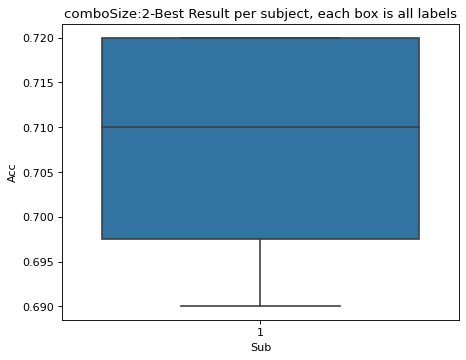

,Acc,Sub,Feat,Kernel,C,Label,Paradigm
0,0.72,1,gausDataSecond_&_stftData_CVFirst,linear,2.5,Up,jjjjudrl
9,0.72,1,gausDataSecond_&_stftData_CVFirst,linear,2.5,Down,jjjjudrl
18,0.70,1,gausDataSecond_&_stftData_CVFirst,linear,2.5,Left,jjjjudrl
27,0.69,1,gausDataSecond_&_stftData_CVFirst,linear,2.5,Right,jjjjudrl


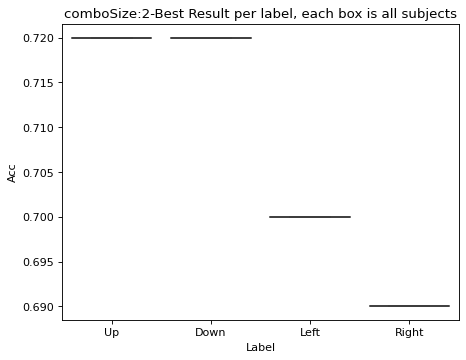

In [250]:
# Not Using HoldOutSet
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
        combinationResultSep=combinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels)
    # table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    # print(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
    plotTop(topPerFeature, featCombos, label, saveTopAvgName=None, perLabel=True)
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
#print(labels)
labelAdded = 0
for label in labels:
    topDF.loc[topDF['Label'] == f"{label + 1 - labelAdded}", 'Label'] = paradigm[1][1][label-labelAdded][0]
    print(paradigm[1][1][label-labelAdded][0])
    # print(topDF.loc[topDF['Label'] == f"{label+1 - labelAdded}", 'Label'])

import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveTop:
    topDF.to_csv(f"topFeaturesResults/topPerSubj-para-{paraName}-cmb-{cmbSize}")
if saveAvgTop:
    topDF.to_csv(f"topFeaturesResultsAvg/topPerSubj-para-{paraName}-cmb-{cmbSize}")
    
if myDataset:
    print("ow")
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
onlyFirst
plt.figure()
sns.boxplot(onlyFirst, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(onlyFirst, y = "Acc", x="Label") # , 
# if "my" in featureSelect:
#     print("ow")
#     onlyFirst = topDF.loc[topDF['Sub'] == "1"]
# else:
#     onlyFirst = topDF

if saveTables:
    onlyFirst.to_csv(f"tables/topPerSubj-para-{paraName}-cmb-{cmbSize}")
onlyFirst
   

0.3
0
126
0.3
0
126
0.3
0
126
0.3
0
126
(36, 7)
Up
Down
Left
Right


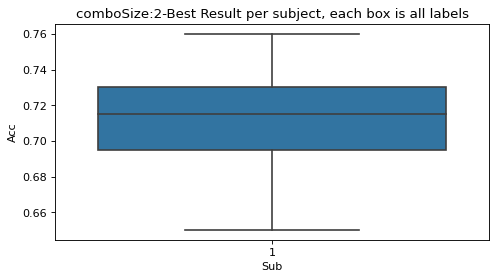

,Acc,Sub,Feat,Kernel,C,Label,Paradigm
0,0.72,1,hilbertData_BCThird_&_gausData_BCSecond,rbf,2.5,Up,jjjjudrl
9,0.76,1,hilbertData_BCThird_&_gausData_BCSecond,rbf,2.5,Down,jjjjudrl
18,0.65,1,hilbertData_BCThird_&_gausData_BCSecond,rbf,2.5,Left,jjjjudrl
27,0.71,1,hilbertData_BCThird_&_gausData_BCSecond,rbf,2.5,Right,jjjjudrl


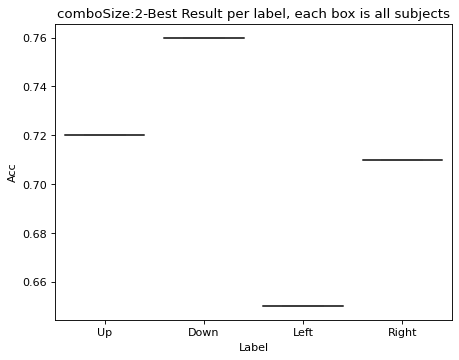

In [251]:
# Using HoldOutSet
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
        combinationResultSep=hcombinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels)
    table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
    plotTop(topPerFeature, featCombos, label, saveTopAvgName=None, perLabel=True)
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
#print(labels)
for label in labels:
    topDF.loc[topDF['Label'] == f"{label+1}", 'Label'] = paradigm[1][1][label][0]
    print(paradigm[1][1][label][0])

import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveHoldTop:
    topDF.to_csv(f"topFeaturesResultsHold/topPerSubj-para-{paraName}-cmb-{cmbSize}")
if myDataset:
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
plt.figure(figsize=[7,3.5])
sns.boxplot(onlyFirst, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(onlyFirst, y = "Acc", x="Label") # , 


if saveTables:
    onlyFirst.to_csv(f"tables/topPerSubjHold-para-{paraName}-cmb-{cmbSize}")
onlyFirst
   

0.3
20
126
[array(['hilbertData_BCThird', 'gausData_BCSecond'], dtype=object), array(['gausData2_GRThird', 'gausData_BCSecond'], dtype=object)]
ow


<Figure size 560x280 with 0 Axes>

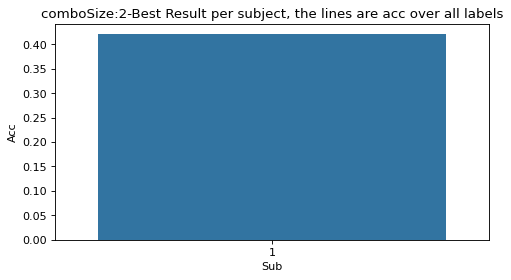

,Acc,Sub,Feat,Kernel,C,Label,Paradigm
0,0.42,1,hilbertData_BCThird_&_gausData_BCSecond,rbf,2.5,4,jjjjudrl


In [252]:
# Average accurracy of all labels, using holdout
allResults = []
import matplotlib.pyplot as plt

subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
    combinationResultSep=hcombinationResultSep,
    allCombinations=allCombinations, 
    featCombos=featCombos,
    label=nrOfLabels,
    nrOfCombination=nrOfCombination,
    labels=labels)
table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
newTopTen = []
for feat in topThreeAllSubjects[1:]:
    newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
newTopTen = np.array(newTopTen)
allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
plt.figure(figsize=[7,3.5])
worstCombos = plotTop(topPerFeature, featCombos, label, saveTopAvgName=saveTopAvgName)


testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
# print(topThreeAllSubjectsList)
# print(topThreeAllSubjectsList.shape)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
# print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if myDataset:
    print("ow")
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
plt.figure(figsize=[7,3.5])
sns.barplot(onlyFirst, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, the lines are acc over all labels")
plt.show()
# plt.title(f"comboSize:{cmbSize}-Best Result per label,  the lines are acc over all labels")
# sns.barplot(topDF, y = "Acc", x="Feat") # , 
topDF
if saveHoldTop:
    topDF.to_csv(f"topFeaturesResultsHold/topPerSubjAvg-para-{paraName}-cmb-{cmbSize}")
if saveTables:
    onlyFirst.to_csv(f"tables/topPerSubjAvgHold-para-{paraName}-cmb-{cmbSize}")
onlyFirst

0.3
10
126
[array(['gausDataSecond', 'stftData_CVFirst'], dtype=object), array(['fftData_BCThird', 'fftData_BCFirst'], dtype=object)]
ow


<Figure size 560x280 with 0 Axes>

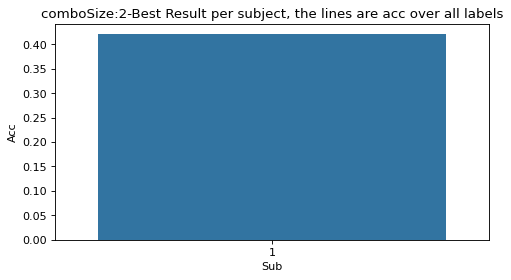

In [253]:
# Average accurracy of all labels, not using holdout
allResults = []
import matplotlib.pyplot as plt

subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
    combinationResultSep=combinationResultSep,
    allCombinations=allCombinations, 
    featCombos=featCombos,
    label=nrOfLabels,
    nrOfCombination=nrOfCombination,
    labels=labels)
table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
newTopTen = []
for feat in topThreeAllSubjects[1:]:
    newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
newTopTen = np.array(newTopTen)
allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
plt.figure(figsize=[7,3.5])
worstCombos = plotTop(topPerFeature, featCombos, label, saveTopAvgName=saveTopAvgName)


testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
# print(topThreeAllSubjectsList)
# print(topThreeAllSubjectsList.shape)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
# print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
import seaborn as sns
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if myDataset:
    print("ow")
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
plt.figure(figsize=[7,3.5])
sns.barplot(onlyFirst, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, the lines are acc over all labels")
plt.show()
# plt.title(f"comboSize:{cmbSize}-Best Result per label,  the lines are acc over all labels")
# sns.barplot(topDF, y = "Acc", x="Feat") # , 
topDF.to_csv(f"topFeaturesResults/topPerSubjAvg-para-{paraName}-cmb-{cmbSize}")
onlyFirst
if saveTables:
    onlyFirst.to_csv(f"tables/topPerSubjAvg-para-{paraName}-cmb-{cmbSize}")

In [254]:
if worstCombos is not None:
    print(list(worstCombos.keys()))
    print(len(list(worstCombos.keys())))
    if cmbSize == 1:
        np.save(f"worstFeatures/worstFeats{cmbSize}{paraName}", list(worstCombos.keys()))


['gausData2_GRThird_&_gausData2_BCFirst', 'fftData_BC_ifftFirst_&_gausData2_BCFirst', 'gausData2_GRThird_&_fftData_BCFirst', 'fftData_BCSecond_&_gausData2_BCFirst', 'gausData_BCThird_&_gausData2_BCFirst', 'fftData_BC_ifft_CVSecond_&_fftData_BCFirst', 'gausData2_GR_CVSecond_&_fftData_BCFirst', 'gausData2_BCThird_&_gausData2_BCFirst', 'hilbertData_BCThird_&_fftData_BCFirst', 'normData_GR_BCSecond_&_gausData2_BCFirst', 'gausDataFirst_&_gausData2_BCFirst']
11


In [255]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


,gausDataFirst_&_stftData_CVFirst,gausDataFirst_&_fftData_BCFirst,gausDataFirst_&_gausData_BCSecond,gausDataFirst_&_gausData2_BCFirst,fftData_BC_ifftFirst_&_stftData_CVFirst,fftData_BC_ifftFirst_&_fftData_BCFirst,fftData_BC_ifftFirst_&_gausData_BCSecond,fftData_BC_ifftFirst_&_gausData2_BCFirst,stftData_CVFirst_&_gausData_BCSecond,stftData_CVFirst_&_gausData2_BCFirst,hilbertDataSecond_&_stftData_CVFirst,hilbertDataSecond_&_fftData_BCFirst,hilbertDataSecond_&_gausData_BCSecond,hilbertDataSecond_&_gausData2_BCFirst,gausDataSecond_&_stftData_CVFirst,gausDataSecond_&_fftData_BCFirst,gausDataSecond_&_gausData_BCSecond,gausDataSecond_&_gausData2_BCFirst,fftData_BCSecond_&_stftData_CVFirst,fftData_BCSecond_&_fftData_BCFirst,fftData_BCSecond_&_gausData_BCSecond,fftData_BCSecond_&_gausData2_BCFirst,hilbertData_BCSecond_&_stftData_CVFirst,hilbertData_BCSecond_&_fftData_BCFirst,hilbertData_BCSecond_&_gausData_BCSecond,hilbertData_BCSecond_&_gausData2_BCFirst,fftData_BC_ifftSecond_&_stftData_CVFirst,fftData_BC_ifftSecond_&_fftData_BCFirst,fftData_BC_ifftSecond_&_gausData_BCSecond,fftData_BC_ifftSecond_&_gausData2_BCFirst,fftData_BC_ifft_CVSecond_&_stftData_CVFirst,fftData_BC_ifft_CVSecond_&_fftData_BCFirst,fftData_BC_ifft_CVSecond_&_gausData_BCSecond,fftData_BC_ifft_CVSecond_&_gausData2_BCFirst,stftData_BCSecond_&_stftData_CVFirst,stftData_BCSecond_&_fftData_BCFirst,stftData_BCSecond_&_gausData_BCSecond,stftData_BCSecond_&_gausData2_BCFirst,gausData_GRSecond_&_stftData_CVFirst,gausData_GRSecond_&_fftData_BCFirst,gausData_GRSecond_&_gausData_BCSecond,gausData_GRSecond_&_gausData2_BCFirst,gausData_GR_BCSecond_&_stftData_CVFirst,gausData_GR_BCSecond_&_fftData_BCFirst,gausData_GR_BCSecond_&_gausData_BCSecond,gausData_GR_BCSecond_&_gausData2_BCFirst,gausData2Second_&_stftData_CVFirst,gausData2Second_&_fftData_BCFirst,gausData2Second_&_gausData_BCSecond,gausData2Second_&_gausData2_BCFirst,gausData2_GRSecond_&_stftData_CVFirst,gausData2_GRSecond_&_fftData_BCFirst,gausData2_GRSecond_&_gausData_BCSecond,gausData2_GRSecond_&_gausData2_BCFirst,gausData2_GR_BCSecond_&_stftData_CVFirst,gausData2_GR_BCSecond_&_fftData_BCFirst,gausData2_GR_BCSecond_&_gausData_BCSecond,gausData2_GR_BCSecond_&_gausData2_BCFirst,gausData2_BCSecond_&_stftData_CVFirst,gausData2_BCSecond_&_fftData_BCFirst,gausData2_BCSecond_&_gausData_BCSecond,gausData2_BCSecond_&_gausData2_BCFirst,gausData2_GR_CV_BCSecond_&_stftData_CVFirst,gausData2_GR_CV_BCSecond_&_fftData_BCFirst,gausData2_GR_CV_BCSecond_&_gausData_BCSecond,gausData2_GR_CV_BCSecond_&_gausData2_BCFirst,gausData2_GR_CVSecond_&_stftData_CVFirst,gausData2_GR_CVSecond_&_fftData_BCFirst,gausData2_GR_CVSecond_&_gausData_BCSecond,gausData2_GR_CVSecond_&_gausData2_BCFirst,normDataSecond_&_stftData_CVFirst,normDataSecond_&_fftData_BCFirst,normDataSecond_&_gausData_BCSecond,normDataSecond_&_gausData2_BCFirst,normData_GRSecond_&_stftData_CVFirst,normData_GRSecond_&_fftData_BCFirst,normData_GRSecond_&_gausData_BCSecond,normData_GRSecond_&_gausData2_BCFirst,normData_GR_BCSecond_&_stftData_CVFirst,normData_GR_BCSecond_&_fftData_BCFirst,normData_GR_BCSecond_&_gausData_BCSecond,normData_GR_BCSecond_&_gausData2_BCFirst,normData_GR_BC_CVSecond_&_stftData_CVFirst,normData_GR_BC_CVSecond_&_fftData_BCFirst,normData_GR_BC_CVSecond_&_gausData_BCSecond,normData_GR_BC_CVSecond_&_gausData2_BCFirst,fftDataThird_&_stftData_CVFirst,fftDataThird_&_fftData_BCFirst,fftDataThird_&_gausData_BCSecond,fftDataThird_&_gausData2_BCFirst,fftData_BCThird_&_stftData_CVFirst,fftData_BCThird_&_fftData_BCFirst,fftData_BCThird_&_gausData_BCSecond,fftData_BCThird_&_gausData2_BCFirst,hilbertData_BCThird_&_stftData_CVFirst,hilbertData_BCThird_&_fftData_BCFirst,hilbertData_BCThird_&_gausData_BCSecond,hilbertData_BCThird_&_gausData2_BCFirst,gausData_BCThird_&_stftData_CVFirst,gausData_BCThird_&_fftData_BCFirst,gausData_BCThird_&_gausData_BCSecond,gausData_BCThird_&_gausData2_BCFirst,fftData_BC_ifft_CVThird_&_stftData_CVFirst,fftData_BC_ifft_CVThird_&_fftData_BCFirst,fftData

In [256]:
print("Top ten highest accuracies")

# topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.42 : subject 1, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5
Accuracy 0.42 : subject 1, feature:gausData2Second_&_stftData_CVFirst, kernellinear, C:2.5
Accuracy 0.42 : subject 1, feature:normDataSecond_&_stftData_CVFirst, kernellinear, C:2.5
Accuracy 0.42 : subject 1, feature:fftData_BCThird_&_fftData_BCFirst, kernellinear, C:2.5
Accuracy 0.42 : subject 2, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5
Accuracy 0.42 : subject 2, feature:gausData2Second_&_stftData_CVFirst, kernellinear, C:2.5
Accuracy 0.42 : subject 2, feature:normDataSecond_&_stftData_CVFirst, kernellinear, C:2.5
Accuracy 0.42 : subject 2, feature:fftData_BCThird_&_fftData_BCFirst, kernellinear, C:2.5
Accuracy 0.42 : subject 3, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5
Accuracy 0.42 : subject 3, feature:gausData2Second_&_stftData_CVFirst, kernellinear, C:2.5


In [257]:
# print("Top ten highest accuracies")
# for subTop in topThreeAllSubjects:
#     subTop.reverse()

In [258]:
# Top results, ordered by subject
arrayOfTopFeatureNames = []

for subTop in topThreeAllSubjects[1:]:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
for subTop in topThreeAllSubjects[1:]:
    print("")
    for top in subTop[1:]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )

# np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)


Accuracy 0.42 : subject 1, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 2, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 3, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 4, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 5, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 6, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 7, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 8, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 9, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 1, feature:gausData2Second_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 2, feature:gausData2Second_&_stftData_CVFirst, kernellinear, C:2

In [259]:
topThreeAllSubjects.sort(reverse=True,  key= lambda i: i[0])

In [260]:
# Top results, ordered by best result

# topThreeAllSubjects.sort()

arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects[:-1]:
    print("")
    for top in subTop[:-1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
# print(newArrayOfTopFeatureNames)
# newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
# if saveTopName is not None:
#     np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
#     print("TopFeatureNameArraySaved")
#     print(newArrayOfTopFeatureNames)


Accuracy 0.42 : subject 9, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 8, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 7, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 6, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 5, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 4, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 3, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 2, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5

Accuracy 0.42 : subject 1, feature:gausDataSecond_&_stftData_CVFirst, kernellinear, C:2.5


In [261]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.         0.31920635 0.31920635 0.31920635 0.31920635 0.31920635
 0.31920635 0.31920635 0.31920635 0.31920635]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377
0,3.6,2.79,2.52,2.79,2.61,2.25,2.52,3.06,2.7,2.43,2.25,2.34,3.33,2.97,2.52,2.97,2.61,2.34,3.24,3.33,2.88,2.61,2.25,2.34,3.69,2.97,2.7,3.42,2.88,2.7,3.42,2.97,2.61,2.7,2.88,2.7,3.15,3.33,2.7,2.7,2.79,2.25,3.78,2.79,2.7,2.79,3.15,2.97,3.24,3.42,2.7,3.06,3.33,2.52,3.51,2.79,2.79,3.33,2.79,2.97,3.33,3.06,2.88,2.61,2.61,2.52,3.6,2.88,2.61,3.15,3.06,3.15,2.79,3.06,2.79,2.88,2.61,2.52,3.42,2.88,3.33,2.88,2.61,2.79,3.33,3.24,3.15,2.88,2.7,2.88,3.15,2.79,2.97,2.61,2.61,2.61,2.79,2.61,2.97,2.79,2.88,2.97,3.42,2.7,2.79,2.88,2.34,2.97,3.42,3.42,3.06,3.42,2.88,3.06,3.51,2.79,2.97,2.79,2.97,2.7,2.61,3.15,2.79,2.79,3.42,2.43,3.51,2.88,2.88,2.97,2.97,2.88,2.61,2.97,2.88,2.79,3.51,2.43,3.78,2.88,2.7,2.97,3.33,2.79,3.06,3.42,2.61,2.97,3.42,2.61,3.42,2.79,2.7,2.7,3.06,2.61,2.61,3.06,3.06,2.7,3.06,2.52,3.33,2.88,2.7,2.52,3.15,2.43,2.7,3.24,2.7,2.79,3.06,2.34,3.69,3.15,2.97,2.97,3.24,2.61,2.79,3.24,2.52,2.7,3.06,2.52,2.7,2.43,2.79,2.79,2.61,2.79,2.61,2.79,2.7,2.61,2.97,2.25,2.97,2.43,2.7,2.52,2.61,2.43,2.7,2.79,2.43,2.97,2.79,2.43,3.78,2.88,2.7,2.88,3.15,2.61,3.06,3.51,2.52,3.24,3.33,2.61,3.42,2.97,2.61,2.61,3.06,2.7,2.88,3.06,2.61,2.88,2.52,2.52,3.33,2.79,2.61,2.61,3.06,2.52,2.52,2.79,2.7,2.52,2.52,2.25,3.24,2.88,2.7,2.25,2.16,2.88,2.97,2.61,3.06,2.52,2.34,2.88,3.51,2.97,2.79,3.24,3.15,3.06,3.69,3.6,3.24,3.15,2.88,2.88,3.69,2.88,2.7,3.78,3.24,3.42,3.51,3.51,3.24,3.51,2.79,2.79,3.24,2.43,2.43,2.52,2.52,2.52,2.88,2.79,2.52,2.43,2.43,2.7,3.24,2.61,2.34,2.79,2.61,3.24,3.15,2.97,3.15,2.61,2.61,2.52,3.24,2.7,2.79,2.79,2.16,2.88,2.88,2.52,3.06,2.61,2.43,2.79,3.33,2.79,2.52,2.88,2.61,2.61,3.33,2.88,3.06,2.97,2.52,2.79,3.42,2.79,2.7,3.69,2.7,3.51,3.33,2.88,3.06,3.33,2.88,3.15,3.06,2.7,3.06,2.52,2.52,2.79,3.6,3.15,3.6,2.7,2.7,3.33,3.06,2.52,2.79,2.34,2.52,2.61,2.61,2.79,2.25,2.25,2.7,2.34,3.42,2.61,2.43,2.52,2.43,2.88,3.06,2.97,2.79,2.43,2.61,2.52


Max average accuracy 3.78


In [262]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
arrayOfTopFeatureNames2 = []
for maxInd,res in zip(top5[:2], top5Vals[:2]):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    arrayOfTopFeatureNames2.append(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()
    
#     # Top results, ordered by subject

# # for subTop in topThreeAllSubjects[1:]:
# #     print("")
# #     for top in subTop[:-1]:
# #         arrayOfTopFeatureNames.append(top[2])
# #         print(
# #                 f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
# #             )
# arrayOfTopFeatureNames2
# # np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
# # np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
# arrayOfTopFeatureNames2 = np.array(arrayOfTopFeatureNames2, dtype=object)
# newArrayOfTopFeatureNames2 = []
# for topNames in arrayOfTopFeatureNames2:
#     splitArray = []
#     if "_&_" in topNames:
#         splitArray = np.array(topNames.split("_&_"), dtype=object)
#     else: 
#         splitArray = [topNames]

#     skip = False  
#     if len(splitArray) < cmbSize:
#         continue
#     newArrayOfTopFeatureNames2.append(splitArray)
    
# print(newArrayOfTopFeatureNames2)
# newArrayOfTopFeatureNames2 = np.array(newArrayOfTopFeatureNames2, dtype=object) 
# if saveTopAvgName is not None:
#     np.save(f"topFeatures/{saveTopAvgName}", newArrayOfTopFeatureNames2)
#     print("TopFeatureNameArraySaved")
#     print(newArrayOfTopFeatureNames2)

Based on combAverage
gausData2Second_&_stftData_CVFirst
linear
3.78

normDataSecond_&_stftData_CVFirst
linear
3.78



In [263]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
gausData2Second_&_stftData_CVFirst
linear
0.42

normDataSecond_&_stftData_CVFirst
linear
0.42

fftData_BCThird_&_fftData_BCFirst
linear
0.42

gausDataSecond_&_stftData_CVFirst
linear
0.42

gausData2_BCSecond_&_stftData_CVFirst
linear
0.41000000000000003



In [264]:
def getRes2(combinationResult, combinationResultSep, allCombinations, featCombos, label, nrOfCombination, labels): 
    headers = np.arange(nrOfCombination)
    subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
    subjectNrList = []  
    comboAverage = np.zeros([1, nrOfCombination])
    comboTotal = np.zeros([1, nrOfCombination])
    nrOfSubjects = np.zeros(nrOfCombination)
    combResLabel = labels[-1]
    topTen = []
    topCombResTen = []
    topThreeAllSubjects = []
    topCombResThreeAllSubjects = []
    topPerFeature = np.zeros([10, len(featCombos)])
    topCombResPerFeature = np.zeros([10, len(featCombos)])
    allCombinations = np.array(allCombinations)
    lowestTopRes = [0, 0]
    for subNr, (cResult, sepResult) in enumerate(zip(combinationResult, combinationResultSep)):
        topThreeThisSubject = []
        topCombResThreeThisSubject = []
        resArray = np.zeros([nrOfCombination])
        if len(cResult) != 0:
            for res, sres in zip(cResult,sepResult):
                cmbNr = int(res[0])
                if onlySignificant == True:
                    if res[1] < minAcc:
                        continue
                res[1] = sres[label+1]
                combRes = sres[combResLabel]
                comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
                comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
                nrOfSubjects[cmbNr] += 1
                subjectResultArray[subNr, cmbNr] = res[1]
                comboName = allCombinations[cmbNr][0]
                nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
                if res[1] > topPerFeature[subNr, nameIndex]:
                    topPerFeature[subNr, nameIndex] = res[1]
                    topCombResPerFeature[subNr, nameIndex] = combRes
                    
                if len(topTen) < 10 or topTen[0][0] < res[1]:

                    if len(topTen) == 10:
                        topTen.reverse()
                        topTen.pop()
                    if len(topCombResTen) == 10:
                        topTen.reverse()
                        topTen.pop()

                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topTen.append([res[1], subNr, dataF, kernel, cVal])
                    topCombResTen.append([combRes, subNr, dataF, kernel, cVal])
                    topTen.sort()
                    topCombResTen.sort()

                
                if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                    if len(topThreeThisSubject) == 2:
                        topThreeThisSubject.reverse()
                        topThreeThisSubject.pop()
                    if len(topCombResThreeThisSubject) == 2:
                        topCombResThreeThisSubject.reverse()
                        topCombResThreeThisSubject.pop()
                    dataF = allCombinations[cmbNr][0]
                    kernel =  allCombinations[cmbNr][1]
                    cVal =  allCombinations[cmbNr][2]
                    topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                    topThreeThisSubject.sort( key= lambda i: i[0])
                    topCombResThreeThisSubject.append([combRes, subNr, dataF, kernel, cVal])
                    topCombResThreeThisSubject.sort( key= lambda i: i[0])
                    
        if len(topThreeThisSubject)>0:
            topThreeAllSubjects.append(topThreeThisSubject)
        if len(topCombResThreeThisSubject)>0:
            topCombResThreeAllSubjects.append(topCombResThreeThisSubject)
        
        
        
    # Print the table!
    comboAverage = comboAverage / nrOfSubjects
    pd.set_option("display.max_columns", None)

    # For loop through zip of headers and columns,
    # If column has all values == None, Remove column and header.
    subjectResultArray = np.array(subjectResultArray)
    emptyCols = []
    atleastOneEmpty = False
    for hcol, in zip(headers):
        if all(subjectResultArray[:,hcol] == None):
            atleastOneEmpty = True
            emptyCols.append(hcol)
    if atleastOneEmpty: 
        subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
        headers = np.delete(headers, np.array(emptyCols),0)
        comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
        comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
        nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)
    return subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature


(36, 7)
Up
Down
Left
Right


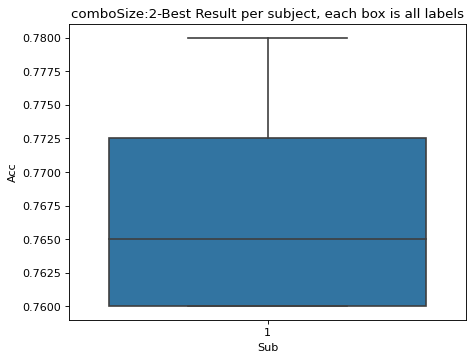

,Acc,Sub,Feat,Kernel,C,Label,Paradigm
0,0.76,1,fftData_BC_ifft_CVThird_&_stftData_CVFirst,linear,2.5,Up,jjjjudrl
9,0.78,1,fftData_BCSecond_&_fftData_BCFirst,linear,2.5,Down,jjjjudrl
18,0.76,1,gausDataSecond_&_gausData2_BCFirst,rbf,2.5,Left,jjjjudrl
27,0.77,1,fftData_BC_ifftFirst_&_gausData_BCSecond,rbf,2.5,Right,jjjjudrl


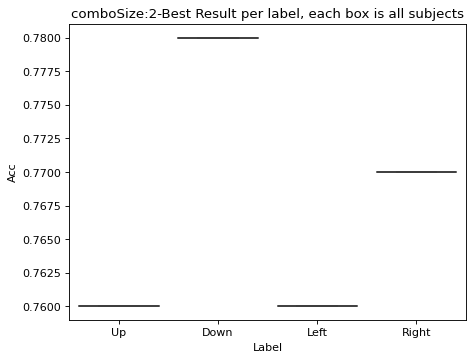

In [265]:
# Not holdout The results below are taken for best feature and hyperparameters per each feature! Highest classification per feature. 
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
        combinationResultSep=combinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels,
        bestSeparate=True)
    table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
    # plotTop(topPerFeature, featCombos, label)
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
import seaborn as sns
for label in labels:
    topDF.loc[topDF['Label'] == f"{label+1}", 'Label'] = paradigm[1][1][label][0]
    print(paradigm[1][1][label][0])
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveTop:
    topDF.to_csv(f"topFeaturesResults/topPerLabel-para-{paraName}-cmb-{cmbSize}")
if saveAvgTop:
    topDF.to_csv(f"topFeaturesResultsAvg/topPerLabel-para-{paraName}-cmb-{cmbSize}")
if myDataset:
    
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
plt.figure()
sns.boxplot(onlyFirst, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(onlyFirst, y = "Acc", x="Label") # , 



if saveTables:
    onlyFirst.to_csv(f"tables/topPerLabel-para-{paraName}-cmb-{cmbSize}")   
onlyFirst

In [266]:
# arrayOfTopFeatureNames = np.array(pd.unique(topDF["Feat"]))
listOfTopFeatNames = []

for sub in [1,2,3,4,5,6,7,8,9]:
    onlySub = topDF[topDF['Sub'] == f"{sub}"]
    arrayOfTopFeatureNames = np.array(pd.unique(onlySub["Feat"]))
    
    if arrayOfTopFeatureNames.shape[0] < nrOfLabels:
        if nrOfLabels == 4:
            if arrayOfTopFeatureNames.shape[0] < 3:
                arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1], arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1]])
            else:
                arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1], arrayOfTopFeatureNames[2], arrayOfTopFeatureNames[0]])
        if nrOfLabels == 2:
            arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[0]])
        # print(arrayOfTopFeatureNames)
        arrayOfTopFeatureNames = np.reshape(arrayOfTopFeatureNames, [-1])
        # print(arrayOfTopFeatureNames)
        # listOfTopFeatNames.extend(arrayOfTopFeatureNames[0])
    listOfTopFeatNames.append(arrayOfTopFeatureNames)
listOfTopFeatNames[2].shape
print(listOfTopFeatNames)
listOfTopFeatNames  = np.concatenate(listOfTopFeatNames)
# for top in listOfTopFeatNames:
arrayOfTopFeatureNames = listOfTopFeatNames

# # np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
# np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeaturesPerLabel/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)
    print(newArrayOfTopFeatureNames.shape)
    

[array(['fftData_BC_ifft_CVThird_&_stftData_CVFirst',
       'fftData_BCSecond_&_fftData_BCFirst',
       'gausDataSecond_&_gausData2_BCFirst',
       'fftData_BC_ifftFirst_&_gausData_BCSecond'], dtype=object), array(['fftData_BC_ifft_CVThird_&_stftData_CVFirst',
       'fftData_BCSecond_&_fftData_BCFirst',
       'gausDataSecond_&_gausData2_BCFirst',
       'fftData_BC_ifftFirst_&_gausData_BCSecond'], dtype=object), array(['fftData_BC_ifft_CVThird_&_stftData_CVFirst',
       'fftData_BCSecond_&_fftData_BCFirst',
       'gausDataSecond_&_gausData2_BCFirst',
       'fftData_BC_ifftFirst_&_gausData_BCSecond'], dtype=object), array(['fftData_BC_ifft_CVThird_&_stftData_CVFirst',
       'fftData_BCSecond_&_fftData_BCFirst',
       'gausDataSecond_&_gausData2_BCFirst',
       'fftData_BC_ifftFirst_&_gausData_BCSecond'], dtype=object), array(['fftData_BC_ifft_CVThird_&_stftData_CVFirst',
       'fftData_BCSecond_&_fftData_BCFirst',
       'gausDataSecond_&_gausData2_BCFirst',
       'fftData_

In [267]:
# listOfTopFeatNames = []
# for sub in [1,2,3,4,5,6,7,8,9]:
#     onlySub = topDF[topDF['Sub'] == f"{sub}"]
#     arrayOfTopFeatureNames = np.array(pd.unique(onlySub["Feat"]))
#     listOfTopFeatNames.append(arrayOfTopFeatureNames)
# listOfTopFeatNames[2].shape
# print(listOfTopFeatNames)
# listOfTopFeatNames  = np.concatenate(listOfTopFeatNames)
# # for top in listOfTopFeatNames:
# listOfTopFeatNames
# # topDF
# # arrayOfTopFeatureNames = np.array(pd.unique(test["Feat"]))
# arrayOfTopFeatureNames

In [268]:
# table = pd.DataFrame(np.array(comboTotal), columns=headers)
# display(table)

# maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

# for maxInd2 in np.where(comboTotal == maxVal2)[1]:
#     print(headers[maxInd2])
#     print(nrOfSubjects[maxInd2])
#     print(
#         f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
#     )
#     print(allCombinations[maxInd2][0])
#     print(allCombinations[maxInd2][1])
#     print(f"C: {allCombinations[maxInd2][2]} ")


(36, 7)
Up
Down
Left
Right


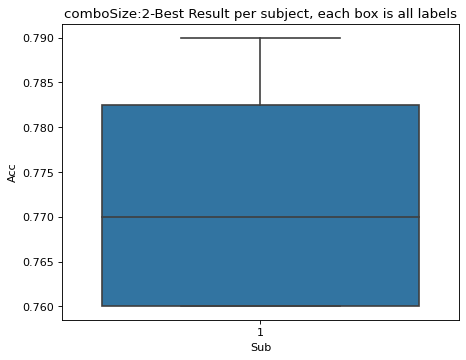

,Acc,Sub,Feat,Kernel,C,Label,Paradigm
0,0.78,1,fftData_BC_ifft_CVThird_&_gausData2_BCFirst,linear,2.5,Up,jjjjudrl
9,0.76,1,normData_GR_BC_CVSecond_&_fftData_BCFirst,sigmoid,2.5,Down,jjjjudrl
18,0.76,1,fftDataThird_&_fftData_BCFirst,linear,2.5,Left,jjjjudrl
27,0.79,1,normData_GRSecond_&_gausData_BCSecond,linear,2.5,Right,jjjjudrl


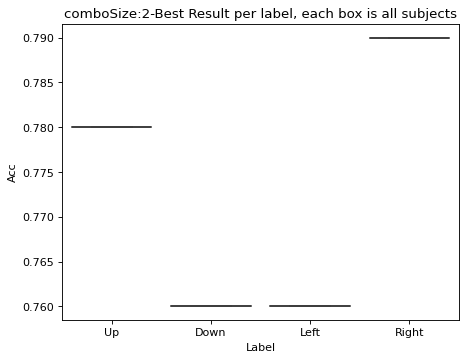

In [269]:
# Using Holdout, The results below are taken for best feature and hyperparameters per each feature! Highest classification per feature. 
allResults = []
import matplotlib.pyplot as plt
for label in labels:
    subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, topThreeAllSubjects, topTen, topPerFeature = getRes(combinationResult = combinationResult, 
        combinationResultSep=hcombinationResultSep,
        allCombinations=allCombinations, 
        featCombos=featCombos,
        label=label,
        nrOfCombination=nrOfCombination,
        labels=labels,
        bestSeparate=True)
    table = pd.DataFrame(subjectResultArray[1:], columns=headers, index=np.arange(9)+1)
    newTopTen = []
    for feat in topThreeAllSubjects[1:]:
        newTopTen.append(np.concatenate([feat[0], [label+1, paraName]]))
    newTopTen = np.array(newTopTen)
    allResults.append([subjectResultArray, comboAverage, comboTotal, nrOfSubjects, headers, newTopTen, newTopTen, topPerFeature])
    # plotTop(topPerFeature, featCombos, label)
    
testDf = pd.DataFrame()
subjectResultArrayList = []
topThreeAllSubjectsList = []
newTopTenList = []

for row in allResults:
    subjectResultArrayList.append(row[0])  
    topThreeAllSubjectsList.append(row[5]) 
    newTopTenList.append(row[6]) 
topThreeAllSubjectsList = np.array(topThreeAllSubjectsList)
topThreeAllSubjectsList = np.reshape(topThreeAllSubjectsList, [-1,topThreeAllSubjectsList.shape[-1] ])
print(topThreeAllSubjectsList.shape)
topDF = pd.DataFrame(topThreeAllSubjectsList, columns = ["Acc", "Sub", "Feat", "Kernel", "C", "Label", "Paradigm" ])
import seaborn as sns
for label in labels:
    topDF.loc[topDF['Label'] == f"{label+1}", 'Label'] = paradigm[1][1][label][0]
    print(paradigm[1][1][label][0])
topDF["Acc"] = pd.to_numeric(topDF["Acc"])
if saveHoldTop:
    topDF.to_csv(f"topFeaturesResultsHold/topPerLabel-para-{paraName}-cmb-{cmbSize}")
# if saveTop:
#     topDF.to_csv(f"topFeaturesResults/topPerLabel-para-{paraName}-cmb-{cmbSize}")
# if saveAvgTop:
#     topDF.to_csv(f"topFeaturesResultsAvg/topPerLabel-para-{paraName}-cmb-{cmbSize}")
if myDataset:
    onlyFirst = topDF.loc[topDF['Sub'] == "1"]
else:
    onlyFirst = topDF
plt.figure()
sns.boxplot(onlyFirst, y = "Acc", x="Sub") # ,  , col="Label"
plt.title(f"comboSize:{cmbSize}-Best Result per subject, each box is all labels")
plt.show()
plt.title(f"comboSize:{cmbSize}-Best Result per label, each box is all subjects")
sns.boxplot(onlyFirst, y = "Acc", x="Label") # , 
#topDF["Sub" == 1]


if saveTables:
    onlyFirst.to_csv(f"tables/topPerLabelHold-para-{paraName}-cmb-{cmbSize}")   
onlyFirst


In [270]:
# arrayOfTopFeatureNames = np.array(pd.unique(topDF["Feat"]))
listOfTopFeatNames = []

for sub in [1,2,3,4,5,6,7,8,9]:
    onlySub = topDF[topDF['Sub'] == f"{sub}"]
    arrayOfTopFeatureNames = np.array(pd.unique(onlySub["Feat"]))
    
    if arrayOfTopFeatureNames.shape[0] < nrOfLabels:
        if nrOfLabels == 4:
            if arrayOfTopFeatureNames.shape[0] < 3:
                arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1], arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1]])
            else:
                arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[1], arrayOfTopFeatureNames[2], arrayOfTopFeatureNames[0]])
        if nrOfLabels == 2:
            arrayOfTopFeatureNames = np.array([arrayOfTopFeatureNames[0], arrayOfTopFeatureNames[0]])
        # print(arrayOfTopFeatureNames)
        arrayOfTopFeatureNames = np.reshape(arrayOfTopFeatureNames, [-1])
        # print(arrayOfTopFeatureNames)
        # listOfTopFeatNames.extend(arrayOfTopFeatureNames[0])
    listOfTopFeatNames.append(arrayOfTopFeatureNames)
listOfTopFeatNames[2].shape
# print(listOfTopFeatNames)
listOfTopFeatNames  = np.concatenate(listOfTopFeatNames)
# for top in listOfTopFeatNames:
arrayOfTopFeatureNames = listOfTopFeatNames

# # np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
# np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topHoldFeaturesPerLabel/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    # print(newArrayOfTopFeatureNames)
    print(newArrayOfTopFeatureNames.shape)
    

[array(['fftData_BC_ifft_CVThird', 'gausData2_BCFirst'], dtype=object), array(['normData_GR_BC_CVSecond', 'fftData_BCFirst'], dtype=object), array(['fftDataThird', 'fftData_BCFirst'], dtype=object), array(['normData_GRSecond', 'gausData_BCSecond'], dtype=object), array(['fftData_BC_ifft_CVThird', 'gausData2_BCFirst'], dtype=object), array(['normData_GR_BC_CVSecond', 'fftData_BCFirst'], dtype=object), array(['fftDataThird', 'fftData_BCFirst'], dtype=object), array(['normData_GRSecond', 'gausData_BCSecond'], dtype=object), array(['fftData_BC_ifft_CVThird', 'gausData2_BCFirst'], dtype=object), array(['normData_GR_BC_CVSecond', 'fftData_BCFirst'], dtype=object), array(['fftDataThird', 'fftData_BCFirst'], dtype=object), array(['normData_GRSecond', 'gausData_BCSecond'], dtype=object), array(['fftData_BC_ifft_CVThird', 'gausData2_BCFirst'], dtype=object), array(['normData_GR_BC_CVSecond', 'fftData_BCFirst'], dtype=object), array(['fftDataThird', 'fftData_BCFirst'], dtype=object), array(['norm